In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix

In [2]:
data = pd.read_csv('C:/Users/USER/Class practice/Machine learning/heart.csv')

In [3]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df1 = data.copy(deep = True)

df1['Sex'] = le.fit_transform(df1['Sex'])
df1['ChestPainType'] = le.fit_transform(df1['ChestPainType'])
df1['RestingECG'] = le.fit_transform(df1['RestingECG'])
df1['ExerciseAngina'] = le.fit_transform(df1['ExerciseAngina'])
df1['ST_Slope'] = le.fit_transform(df1['ST_Slope'])
print(df1)

     Age  Sex  ChestPainType  RestingBP  Cholesterol  FastingBS  RestingECG  \
0     40    1              1        140          289          0           1   
1     49    0              2        160          180          0           1   
2     37    1              1        130          283          0           2   
3     48    0              0        138          214          0           1   
4     54    1              2        150          195          0           1   
..   ...  ...            ...        ...          ...        ...         ...   
913   45    1              3        110          264          0           1   
914   68    1              0        144          193          1           1   
915   57    1              0        130          131          0           1   
916   57    0              1        130          236          0           0   
917   38    1              2        138          175          0           1   

     MaxHR  ExerciseAngina  Oldpeak  ST_Slope  Hear

In [4]:
from sklearn.preprocessing import MinMaxScaler,StandardScaler
mms = MinMaxScaler() # Normalization
ss = StandardScaler() # Standardization

df1['Oldpeak'] = mms.fit_transform(df1[['Oldpeak']])
df1['Age'] = ss.fit_transform(df1[['Age']])
df1['RestingBP'] = ss.fit_transform(df1[['RestingBP']])
df1['Cholesterol'] = ss.fit_transform(df1[['Cholesterol']])
df1['MaxHR'] = ss.fit_transform(df1[['MaxHR']])
df1.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,-1.433140,1,1,0.410909,0.825070,0,1,1.382928,0,0.295455,2,0
1,-0.478484,0,2,1.491752,-0.171961,0,1,0.754157,0,0.409091,1,1
2,-1.751359,1,1,-0.129513,0.770188,0,2,-1.525138,0,0.295455,2,0
3,-0.584556,0,0,0.302825,0.139040,0,1,-1.132156,1,0.465909,1,1
4,0.051881,1,2,0.951331,-0.034755,0,1,-0.581981,0,0.295455,2,0


In [5]:
features = df1[df1.columns.drop(['HeartDisease'])].values
target = df1['HeartDisease'].values
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size = 0.2, random_state = 2)

In [6]:
# 定義模型
classifier_rf = RandomForestClassifier(random_state = 42)

# 定義參數網格
param_grid = {
    'n_estimators': [65, 70, 75],  # 樹的數量
    'max_depth': [None, 10, 20, 30],  # 樹的最大深度
    'min_samples_split': [4, 5, 6],  # 分裂節點的最小樣本數
    'min_samples_leaf': [1, 2, 4]  # 葉節點的最小樣本數
}

In [7]:
grid_search = GridSearchCV(
    estimator = classifier_rf,  # 模型
    param_grid = param_grid,  # 參數網格
    scoring = 'accuracy',  # 評估指標，例如 'accuracy', 'f1', 'roc_auc'
    cv = 5,  # 交叉驗證摺數
    verbose = 2,  # 日誌輸出級別
    n_jobs = -1  # 使用所有可用 CPU 核心
)

In [8]:
grid_search.fit(x_train, y_train)

# 最佳參數組合
print("Best Parameters:", grid_search.best_params_)

# 最佳模型
best_model = grid_search.best_estimator_

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 70}


In [9]:
# 使用測試集預測
y_pred = best_model.predict(x_test)

# 評估準確度
print("Test Accuracy:", accuracy_score(y_test, y_pred))

Test Accuracy: 0.8586956521739131


In [10]:
def model(classifier):
    
    classifier.fit(x_train,y_train)
    prediction = classifier.predict(x_test)
    cv = RepeatedStratifiedKFold(n_splits = 10,n_repeats = 3,random_state = 1)
    print("Accuracy : ",'{0:.2%}'.format(accuracy_score(y_test,prediction)))
    print("Cross Validation Score : ",'{0:.2%}'.format(cross_val_score(classifier,x_train,y_train,cv = cv,scoring = 'roc_auc').mean()))
    print("ROC_AUC Score : ",'{0:.2%}'.format(roc_auc_score(y_test,prediction)))
    
    # 預測概率
    y_proba = classifier.predict_proba(x_test)[:, 1]
    # 計算 ROC 曲線
    fpr, tpr, thresholds = roc_curve(y_test, y_proba)
    # 計算 AUC 值
    roc_auc = auc(fpr, tpr)

    # # 繪製 ROC 曲線
    plt.figure()
    plt.plot(fpr, tpr, color='skyblue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.savefig('C:/Users/USER/Desktop/ROC_curve.png', format='png', dpi=300, bbox_inches='tight')
    plt.show()

def model_evaluation(classifier):
    
    # 計算混淆矩陣
    cm = confusion_matrix(y_test,classifier.predict(x_test))
    
    # 計算每個格子的數值及百分比
    names = ['True Neg','False Pos','False Neg','True Pos']
    counts = [value for value in cm.flatten()]
    percentages = ['{0:.2%}'.format(value) for value in cm.flatten()/np.sum(cm)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(names,counts,percentages)]
    labels = np.asarray(labels).reshape(2,2)
    
    # 繪製混淆矩陣
    sns.heatmap(cm,annot = labels,cmap = 'Blues',fmt ='', xticklabels=['Predicted Negative', 'Predicted Positive'], yticklabels=['Actual Negative', 'Actual Positive'])
    plt.xlabel('Predicted Labels')
    plt.ylabel('Actual Labels')
    plt.title('Confusion Matrix')
    plt.savefig('C:/Users/USER/Desktop/confusion_matrix.png', format='png', dpi=300, bbox_inches='tight')
    plt.show()

    # 顯示分類報告
    print(classification_report(y_test,classifier.predict(x_test)))

Accuracy :  85.87%
Cross Validation Score :  93.15%
ROC_AUC Score :  85.78%


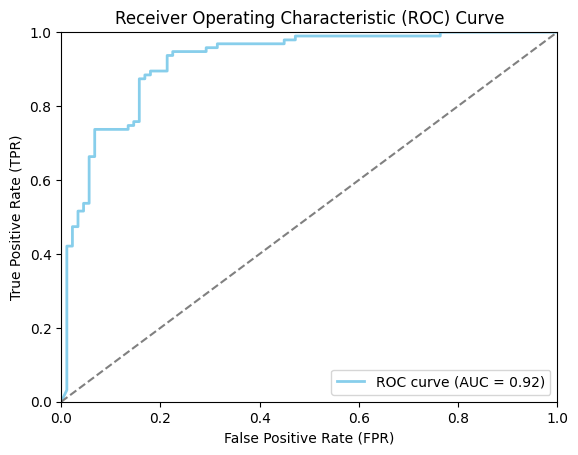

In [11]:
model(best_model)

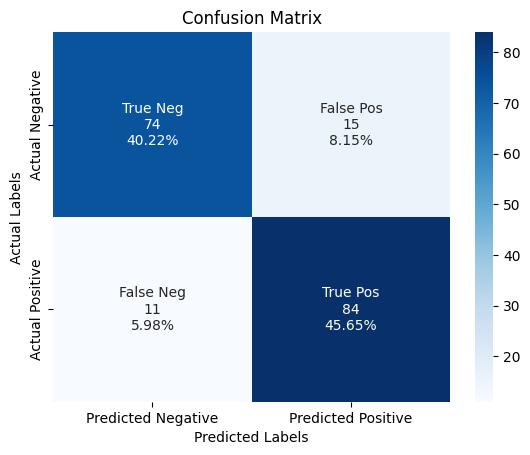

              precision    recall  f1-score   support

           0       0.87      0.83      0.85        89
           1       0.85      0.88      0.87        95

    accuracy                           0.86       184
   macro avg       0.86      0.86      0.86       184
weighted avg       0.86      0.86      0.86       184



In [12]:
model_evaluation(best_model)

In [13]:
import joblib
import streamlit as st

In [14]:
# 儲存模型
joblib.dump(best_model, 'random_forest_model.pkl')

['random_forest_model.pkl']